In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
current_directory = os.getcwd()
print(current_directory)
train = pd.read_csv('data/train.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test.csv')

D:\GitHub\keras_learning\training_project\tabular_playground_series_Apr_2022


In this competition, you'll classify 60-second sequences of sensor data, indicating whether a subject was in either of two activity states for the duration of the sequence.

在本次競賽中，您將對 60 秒的感測器資料序列進行分類，找出受試者在序列持續時間內處於兩種活動狀態的其中一種。

## Files and Field Descriptions
- train.csv - the training set, comprising ~26,000 60-second recordings of thirteen biological sensors for almost one thousand experimental participants
    - sequence - a unique id for each sequence
    - subject - a unique id for the subject in the experiment
    - step - time step of the recording, in one second intervals
    - sensor_00 - sensor_12 - the value for each of the thirteen sensors at that time step
- train_labels.csv - the class label for each sequence.
    - sequence - the unique id for each sequence.
    - state - the state associated to each sequence. This is the target which you are trying to predict.
- test.csv - the test set. For each of the ~12,000 sequences, you should predict a value for that sequence's state.
- sample_submission.csv - a sample submission file in the correct format.

In [3]:
train

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424


In [4]:
train_labels

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
25963,25963,1
25964,25964,0
25965,25965,1
25966,25966,1


In [5]:
test

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.00000,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.00000,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.00000,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.00000,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.00000,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733075,38185,773,55,0.211747,2.005252,-1.33282,0.695575,-0.161327,-1.193717,0.421676,0.869466,0.0,-1.536850,0.388101,2.205761,-91.610827
733076,38185,773,56,-0.826121,-2.468487,-1.33282,0.381416,0.144745,1.060583,-0.765938,0.288550,0.2,-1.956647,-0.032158,-1.794239,72.414749
733077,38185,773,57,0.755023,1.469538,-1.33282,-1.253097,-0.414802,0.007479,0.907104,-1.556489,0.4,4.341763,0.150273,0.641975,-34.065644
733078,38185,773,58,-0.187017,0.714286,-1.33282,0.077876,1.323245,0.159312,-0.397996,0.306870,0.1,-1.013728,-0.608616,0.317901,65.659420


由上表與題目提示可得知，每一秒會記錄一列，每 60 列代表一個 `sequence`

確認資料是否有缺漏，本題的資料都很完美，沒有有缺漏的地方

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


## 特徵工程

萃取需要的資料

In [7]:
groups = train['sequence']

In [8]:
train

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424


In [9]:
Window = 60
y = train_labels['state'].to_numpy()
train = train.loc[:, ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']]
test = test.loc[:, ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']]


In [10]:
y

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [11]:
y.shape

(25968,)

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train)
X_train = sc.transform(train)
X_test = sc.transform(test)

In [13]:
X_train

array([[-0.07399419,  0.02575496,  0.52994079, ..., -0.51394323,
         0.11817284,  0.12176644],
       [-0.16846171,  0.03076355,  0.52994079, ...,  0.0429771 ,
        -0.05024707,  0.01191576],
       [ 0.1227889 , -0.15741634,  0.52994079, ...,  0.23412207,
        -0.12855551, -0.12077463],
       ...,
       [-0.21816616,  0.09778326, -0.63026452, ...,  0.37370821,
         0.36013458,  0.024033  ],
       [ 0.48089345,  0.38875849, -0.56789148, ..., -0.47735358,
         0.08117493,  0.00570458],
       [-0.42744803, -0.84049264, -0.48521092, ..., -0.21845335,
        -0.31990049, -0.03961523]])

## 整理資料

準備進入訓練的資料格式：設定 sequence
sequence 設為 60 ，代表過去 60 秒的資訊。

In [14]:
y_train = y.copy()
X_train = X_train.reshape(-1, Window, X_train.shape[-1])
X_test = X_test.reshape(-1, Window, X_test.shape[-1])

In [15]:
print(y_train.shape, X_train.shape, X_test.shape)

(25968,) (25968, 60, 13) (12218, 60, 13)


In [16]:
X_train

array([[[-7.39941949e-02,  2.57549585e-02,  5.29940790e-01, ...,
         -5.13943234e-01,  1.18172836e-01,  1.21766440e-01],
        [-1.68461709e-01,  3.07635486e-02,  5.29940790e-01, ...,
          4.29771001e-02, -5.02470657e-02,  1.19157570e-02],
        [ 1.22788905e-01, -1.57416339e-01,  5.29940790e-01, ...,
          2.34122074e-01, -1.28555511e-01, -1.20774628e-01],
        ...,
        [ 3.66369758e-01, -5.87678086e-01,  3.84887188e-01, ...,
          9.43643246e-01, -6.54924449e-01, -1.84052370e-01],
        [-2.11943389e+00,  8.23074813e-01,  3.84887188e-01, ...,
          2.32894843e-01,  2.98395750e-01, -6.83245867e-01],
        [ 2.83357057e+00, -4.06891831e-01,  3.84887188e-01, ...,
         -8.30538459e-01,  3.22682717e-01, -1.29474183e+00]],

       [[-2.50428001e+00, -3.19630807e-02, -9.20148225e-01, ...,
          6.09078938e-01,  3.37209501e-01, -3.17886919e-01],
        [ 6.14310650e-01,  1.33320395e-01, -8.31077714e-01, ...,
          6.16109001e-01,  5.27419578e

## 搭建 LSTM 網路

In [17]:
from keras import Model
from keras.layers import *
from keras.callbacks import *
from keras.metrics import AUC

In [28]:
def get_model():
    input_layer = Input(shape=(X_train.shape[1:]))


    x1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    x21 = Bidirectional(LSTM(64, return_sequences=True))(x1)
    # x22 = Bidirectional(LSTM(32, return_sequences=True))(input_layer)
    # l2 = Concatenate(axis=2)([x21, x22])

    # x31 = Bidirectional(LSTM(16, return_sequences=True))(l2)
    x32 = Bidirectional(LSTM(64, return_sequences=True))(x21)
    # l3 = Concatenate(axis=2)([x31, x32])

    # x41 = Bidirectional(LSTM(8, return_sequences=True))(l3)
    x42 = Bidirectional(LSTM(32, return_sequences=True))(x32)
    # l4 = Concatenate(axis=2)([x41, x42])

    # l5 = Concatenate(axis=2)([x1, l2, l3, l4])
    x7 = Dense(128, activation='selu')(x42)
    x8 = Dropout(0.5)(x7)
    f = Flatten()(x8)
    output_layer = Dense(units=1, activation="sigmoid")(f)
    model = Model(inputs=input_layer, outputs=output_layer, name='DNN_Model')
    model.compile(optimizer="adam",loss="binary_crossentropy", metrics=[AUC(name = 'auc')])
    return  model


model = get_model()
model.summary()


Model: "DNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 13)]          0         
                                                                 
 bidirectional_39 (Bidirecti  (None, 60, 256)          145408    
 onal)                                                           
                                                                 
 bidirectional_40 (Bidirecti  (None, 60, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_41 (Bidirecti  (None, 60, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_42 (Bidirecti  (None, 60, 64)           41216     
 onal)                                                   

Reson for why add Fallten in last dense

An LSTM layer consists of different LSTM cells that are processed sequentially. As seen in the figure below, the first cell takes an input/embedding calculates a hidden state and the next cell uses its input and the hidden state at previous time step to compute its own hidden state. Basically the arrows between the cells also pass the hidden states. <b>If you do return_sequences=False, the lstm layer only outputs the very last hidden state! (h_4 in the figure). So, all those information from all inputs and cells are embedded in a single fixed size information and it can not contain lots of information.</b> This is why, your accuracy is not good when you only use the last hidden state.

When you do `return_sequences=True`, lstm layer outputs every hidden state, so the next layers have access to all hidden states and they contain naturally more information. However, the LSTM layer returns a matrix. You can also see this in your model summary. It returns a matrix of size (None, 500, 128). None is basically number of samples in your batch, you can forget about it. 500 is your input size, and 128 is your hidden state size. <b>The dense layer can not process a matrix, it has to be a vector. That why you need to apply flatten and what it does is basically just to open up the 2D matrix and represent it as 1D vector.</b> Therefore, the size of your Flatten layer is 64000 because 500*128 = 64000. And Of course with more hidden states, the accuracy is better as they contain more information.

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [25]:
def plot_hist(hist, metric='auc', ax=None, fold=0):
    if ax==None:
        plt.plot(hist.history[metric])
        plt.plot(hist.history["val_" + metric])
        plt.title(f"model performance fold {fold}")
        plt.ylabel("area_under_curve")
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        return
    else:
        ax.plot(hist.history[metric])
        ax.plot(hist.history["val_" + metric])
        ax.set_title(f"model performance fold {fold}")
        ax.set_ylabel("area_under_curve")
        ax.set_xlabel("epoch")
        ax.legend(["train", "validation"], loc="upper left")

1
Fold: 1 Epoch 1/60
609/609 [==============================] - 38s 49ms/step - loss: 0.6393 - auc: 0.6778 - val_loss: 0.5124 - val_auc: 0.8378 - lr: 0.0010
Epoch 2/60
609/609 [==============================] - 29s 47ms/step - loss: 0.4717 - auc: 0.8569 - val_loss: 0.4312 - val_auc: 0.8870 - lr: 0.0010
Epoch 3/60
609/609 [==============================] - 29s 48ms/step - loss: 0.3929 - auc: 0.9035 - val_loss: 0.3753 - val_auc: 0.9141 - lr: 0.0010
Epoch 4/60
609/609 [==============================] - 30s 49ms/step - loss: 0.3418 - auc: 0.9279 - val_loss: 0.3687 - val_auc: 0.9247 - lr: 0.0010
Epoch 5/60
609/609 [==============================] - 30s 49ms/step - loss: 0.3046 - auc: 0.9431 - val_loss: 0.3238 - val_auc: 0.9361 - lr: 0.0010
Epoch 6/60
609/609 [==============================] - 30s 49ms/step - loss: 0.2831 - auc: 0.9510 - val_loss: 0.3017 - val_auc: 0.9444 - lr: 0.0010
Epoch 7/60
609/609 [==============================] - 29s 48ms/step - loss: 0.2554 - auc: 0.9601 - val_loss:

KeyboardInterrupt: 

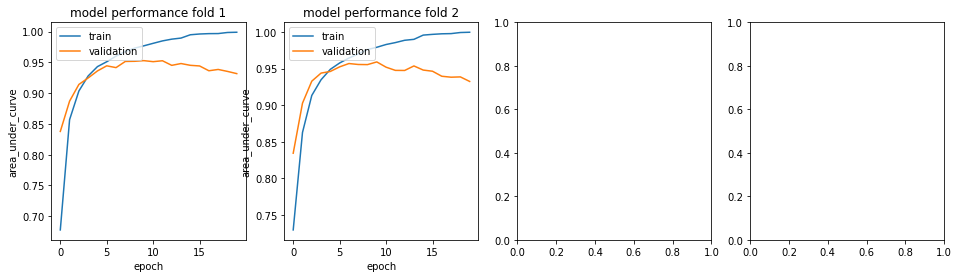

In [29]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import roc_auc_score
import gc

def fit_model(folds, epochs=60, batch_size=32, verbose=True):
    test_preds = []
    auc = []
    nfold = folds
    ncols = 5 if folds > 5 else folds
    nrows = int(round(nfold / ncols))

    col, row = 0, 0
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, round(nrows*16/ncols)))
    print(nrows)

    kf = GroupKFold(n_splits=nfold)
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train, groups.unique())):
        print(f"Fold: {fold+1}", end=' ')
        X_train_part, X_valid = X_train[train_idx], X_train[test_idx]
        y_train_part, y_valid = y_train[train_idx], y_train[test_idx]

        model = get_model()
        lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
        es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)
        history = model.fit(X_train_part, y_train_part, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size,
                            callbacks=[es,lr], verbose=verbose)

        y_pred = model.predict(X_valid).squeeze()
        auc_score = roc_auc_score(y_valid, y_pred)
        print(f'auc: {round(auc_score, 5)}')
        test_preds.append(model.predict(X_test).squeeze())
        auc.append(auc_score)
        model.save('fold_{}.h5'.format(nfold))
        plot_hist(history, metric='auc', ax=axes[col] if nrows <= 1 else axes[row][col], fold=fold+1)
        del X_train_part, X_valid, y_train_part, y_valid, model, history
        gc.collect()

        col += 1
        if col >= ncols:
            row += 1
            col = 0

    return (test_preds, auc)

folds = 4
(test_preds, auc) = fit_model(folds, epochs=60, batch_size=32)

print(test_preds)

## 預測真實資料

In [ ]:
print(f"the mean AUC for the {folds} folds is : {round(np.mean(auc)*100,3)}")

In [ ]:
sub_data = pd.read_csv("data/sample_submission.csv")

In [ ]:
sub_data['state'] = sum(test_preds)/folds

In [ ]:
sub_data.state = (sub_data.state > 0.5).astype(int)

In [ ]:
sub_data

In [ ]:
sub_data.to_csv('submission.csv', index=False)